In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
sys.path.insert(1,'./code')
from visualize import plot_raw_data, get_population_data, plot_results
from EM import TransformToProb, RunEM
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import pyparticleest.utils.kalman as kalman
from scipy.stats import bernoulli

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = x_k  + v_k = f(x_k) + v_k,
    # y_k = 0 + e_k = g(x_k) + e_k,
    # x(0) ~ N(0,P0), v_k ~ N(0,Q), e_k ~ Binom(50,\exp(x_{k})/(1+\exp(x_{k})))

    def __init__(self, P0, Q):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q)

    def calc_g(self, particles, t):
    # Calculate value of g(\xi_t,t)
         return np.zeros([len(particles),1])
    
    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        return particles
    
    def measure(self, particles, y, t):
        """
        Return the log-pdf value of the measurement
        Args:
         - particles  (array-like): Model specific representation
           of all particles, with first dimension = N (number of particles)
         - y (array-like):  measurement
         - t (float): time-stamp
        Returns:
         (array-like) with first dimension = N, logp(y|x^i)
        """
        N = len(particles)
        trial = 50
        yrep = np.repeat(np.asarray(y), N, 0)
        coefficient = scipy.special.binom(trial, yrep)
        #lpy = scipy.stats.binom.logpmf(yrep,50,np.exp(particles[:,0])/(1.0 + np.exp(particles[:,0])),loc=0)
        lpy = np.log(coefficient) + yrep * particles[:,0] - trial * np.log(1 + np.exp(particles[:,0]))
        return lpy

In [24]:
# Forward particles
N = 2000
# Backward trajectories
M = 1
# trials
trial = 50
# cluster
cluster = 2

sigma_ls = np.arange(0.01, 1.51, 0.05)
pi_ls = 0.5

print sigma_ls

[ 0.01  0.06  0.11  0.16  0.21  0.26  0.31  0.36  0.41  0.46  0.51  0.56
  0.61  0.66  0.71  0.76  0.81  0.86  0.91  0.96  1.01  1.06  1.11  1.16
  1.21  1.26  1.31  1.36  1.41  1.46]


In [25]:
mat = np.loadtxt('train_data.txt')
Y = mat[:,1:]
T = Y.shape[1]
n = Y.shape[0]
print Y.shape

(20, 3000)


In [26]:
loglikelihood = np.empty([len(sigma_ls),n])

In [27]:
for i in range(len(sigma_ls)):
    for j in range(n):
        P0 = sigma_ls[i] * np.eye(1)
        Q = sigma_ls[i] * np.eye(1)
        model = StdNonLin(P0, Q)
        sim = simulator.Simulator(model,u=None,y=Y[j,:])
        #sim = unnormalizedSimulator(model, u=None, y=Y)
        sim.simulate(N, M, filter='PF', smoother='ancestor', meas_first=False)
        (est_filt, w_filt) = sim.get_filtered_estimates()
        #weight=np.exp(logweight)
        #maxlogweight = np.max(w_unnormalized,axis=1)
        #weight = np.exp(w_unnormalized - np.reshape(np.repeat(maxlogweight, N),(T, N)))
        www = scipy.stats.binom.logpmf(np.reshape(np.repeat(Y[j,:],N),[T,N]),trial, np.exp(est_filt[1:,:,0])/(1.0 + np.exp(est_filt[1:,:,0])), loc=0)
        maxlogweight = np.max(www,axis=1)
        weight = np.exp(www - np.reshape(np.repeat(maxlogweight, N),(T, N)))
        loglikelihood[i,j]=np.sum(np.log(np.sum(weight, axis = 1)/N)) + np.sum(maxlogweight)
        #loglikelihood[i]=np.sum(np.log(np.sum(weight, axis = 1)/N))

In [147]:
kkk = pickle.load(open('/Users/zyzrdfz/Desktop/gwungwun/mixture_loglikelihood.p','rb'))
print kkk

[[-4039.59797623 -3253.55112446 -4159.57859417 ..., -2561.19061536
  -2722.70752544 -3034.76107701]
 [-4039.59797623 -3253.55112446 -4159.57859417 ..., -2561.19061536
  -2722.70752544 -3034.76107701]
 [-4039.59797623 -3253.55112446 -4159.57859417 ..., -2561.19061536
  -2722.70752544 -3034.76107701]
 ..., 
 [-4039.59797623 -3253.55112446 -4159.57859417 ..., -2561.19061536
  -2722.70752544 -3034.76107701]
 [-4039.59797623 -3253.55112446 -4159.57859417 ..., -2561.19061536
  -2722.70752544 -3034.76107701]
 [-4039.59797623 -3253.55112446 -4159.57859417 ..., -2561.19061536
  -2722.70752544 -3034.76107701]]


In [17]:
pickle.dump(loglikelihood, open('/Users/zyzrdfz/Desktop/gwungwun/mixture_loglikelihood_1000.p','wb'))

In [30]:
loglikelihood.shape

(30, 20)

## Log-Likelihood of Mixture

In [31]:
likelihood = np.empty([len(sigma_ls), len(sigma_ls)])
maxloglikelihood = np.max(loglikelihood, axis=0)
w = np.exp(loglikelihood - maxloglikelihood)
for k in range(len(sigma_ls)):
    for l in range(len(sigma_ls)):
        likelihood [k,l] = np.sum(np.log(w[k,:]*0.5+w[l,:]*0.5)) + np.sum(maxloglikelihood)

In [14]:
loglikelihood.shape

(30, 20)

In [85]:
likelihood = np.empty([len(sigma_ls), len(sigma_ls)])
#maxloglikelihood = np.max(loglikelihood, axis=0)
#w = np.exp(loglikelihood - maxloglikelihood)
for k in range(len(sigma_ls)):
    for l in range(len(sigma_ls)):
        maxloglikelihood = Max(loglikelihood[k,:],loglikelihood[l,:],n)
        w1 = np.exp(loglikelihood[k,:] - maxloglikelihood)
        w2 = np.exp(loglikelihood[l,:] - maxloglikelihood)
        likelihood [k,l] = np.sum(np.log(w1*0.5+w2*0.5)) + np.sum(maxloglikelihood)
        #likelihood [k,l] = np.sum(np.log(w[k,:]*0.5+w[l,:]*0.5)) + np.sum(maxloglikelihood)

In [81]:
def Max(a,b,n):
    maxloglikelihood = a
    for i in range(n):
        if a[i]<b[i]:
            maxloglikelihood[i] = b[i]
    return maxloglikelihood

In [102]:
np.sum(maxloglikelihood)

-69272.739995843935

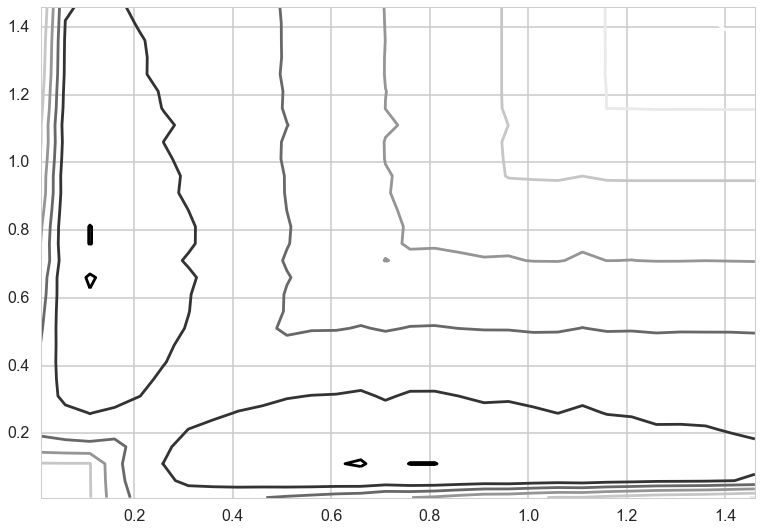

In [32]:
plt.contour(sigma_ls,sigma_ls,likelihood)

In [34]:
likelihood[2,:]

array([-72046.3517674 , -72036.13226805, -72032.48882379, -70666.64539597,
       -69833.41015637, -69587.98529295, -69251.90772006, -69134.60809957,
       -69028.79662845, -68961.84924146, -68871.2155654 , -68829.29755486,
       -68815.96413959, -68771.46644035, -68908.40424963, -68791.65399361,
       -68791.58161862, -68879.66928832, -68962.88524331, -68936.22936527,
       -69030.82907668, -69097.85027134, -69041.98957687, -69160.17628579,
       -69213.50293288, -69296.41128088, -69312.86105893, -69337.10941739,
       -69413.26786539, -69492.87582878])

In [17]:
pickle.dump(likelihood, open('/Users/zyzrdfz/Desktop/gwungwun/mixture_likelihood.p','wb'))